In [21]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import wave
from scipy.io import wavfile
import contextlib
import os
import matplotlib.pyplot as plt

# total call & total syl

In [4]:
def num_target(file, time_range):
    df = pd.read_csv(file)
    return len(df.loc[df['stop_seconds']<time_range])
def name_target(file, name):
    df = pd.read_csv(file)
    return len(df.loc[df['name']==name])

In [2]:
home_path = '/Volumes/RENATA_X/Vallentinlab'
birdfolder = 'bird7159'
channel = 'chan0'
dayinuse = np.loadtxt(os.path.join(home_path,birdfolder+'_sorted','dayinuse.txt'),delimiter=',')

In [23]:
#chan0_csv = os.path.join(home_path,birdfolder+'_sorted','chan0/dph%03d_filter_denoised_annotations.csv'%day)
#chan6_csv = os.path.join(home_path,birdfolder+'_sorted','chan6/dph%03d_filtered_denoised_sampled_annotations.csv'%day)
    
    
call_nums = [num_target(os.path.join(home_path,birdfolder+'_sorted','chan0/dph%03d_filter_denoised_annotations.csv'%day),180) for day in dayinuse]
syl_nums = [name_target(os.path.join(home_path,birdfolder+'_sorted','chan6/dph%03d_filtered_denoised_sampled_annotations.csv'%day),4) for day in dayinuse]

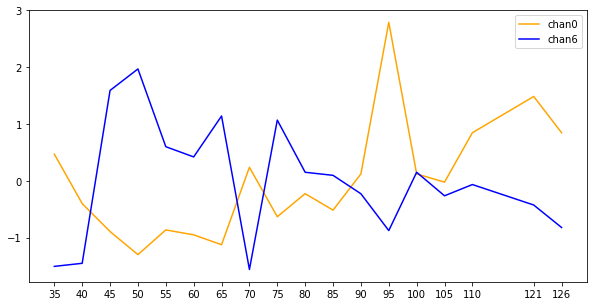

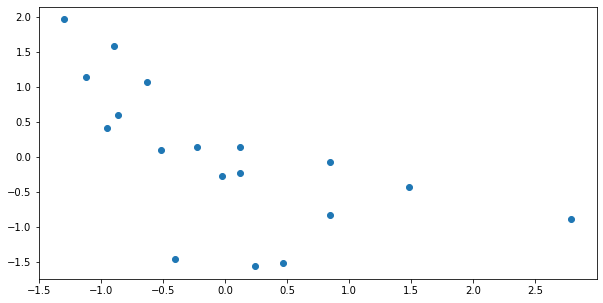

In [24]:
plt.figure(figsize=(10,5))
plt.plot(dayinuse,(np.array(call_nums)-np.mean(call_nums))/np.std(call_nums),c='orange',label='chan0')
plt.plot(dayinuse,(np.array(syl_nums)-np.mean(syl_nums))/np.std(syl_nums),c='blue',label='chan6')
plt.xticks(dayinuse)
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.scatter((np.array(call_nums)-np.mean(call_nums))/np.std(call_nums),(np.array(syl_nums)-np.mean(syl_nums))/np.std(syl_nums))
plt.show()

# call during syl, call before syl, call after syl

In [25]:
def get_syl_related_call(chan0_csv, chan6_csv):
    df_chan0 = pd.read_csv(chan0_csv)
    df_chan6 = pd.read_csv(chan6_csv)
    start_seconds = (df_chan6.loc[df_chan6.name==4].start_seconds).values## name =='syllable'
    stop_seconds = (df_chan6.loc[df_chan6.name==4].stop_seconds).values
    start_interval = np.zeros((len(df_chan0.start_seconds.values),len(start_seconds)))
    stop_interval = np.zeros((len(df_chan0.stop_seconds.values),len(stop_seconds)))
    for syl_index in range(len(start_seconds)):
        start_interval[:,syl_index] = start_seconds[syl_index] - df_chan0.start_seconds.values ## for each syl, syl start-cal start
        stop_interval[:,syl_index] = stop_seconds[syl_index] - df_chan0.stop_seconds.values 
    call_before_syl = len(np.where((start_interval>0)&(start_interval<1))[0]) # syl starts 0-1 second after cal
    call_after_syl = len(np.where((stop_interval<0)&(stop_interval>-1))[0]) # syl ends 0-1 second before cal
    call_during_syl = len(np.where((stop_interval>0)&(start_interval<0))[0])# 
    return call_before_syl,call_after_syl,call_during_syl

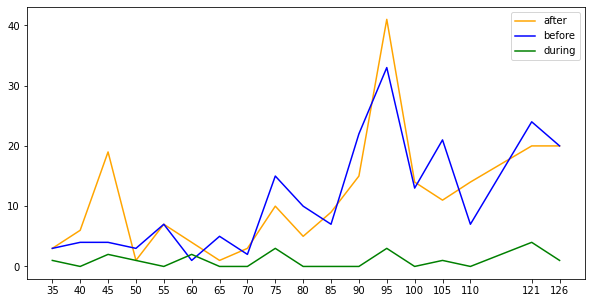

In [26]:
call_before_syls = []
call_after_syls = []
call_during_syls = []
for day in dayinuse:
    chan0_csv = os.path.join(home_path,birdfolder+'_sorted','chan0/dph%03d_filter_denoised_annotations.csv'%day)
    chan6_csv = os.path.join(home_path,birdfolder+'_sorted','chan6/dph%03d_filtered_denoised_sampled_annotations.csv'%day)
    call_before_syl, call_after_syl,call_during_syl = get_syl_related_call(chan0_csv,chan6_csv)
    call_after_syls.append(call_after_syl)
    call_before_syls.append(call_before_syl)
    call_during_syls.append(call_during_syl)
plt.figure(figsize=(10,5))
plt.plot(dayinuse,np.array(call_after_syls),c='orange',label='after')
plt.plot(dayinuse,np.array(call_before_syls),c='blue',label='before')
plt.plot(dayinuse,np.array(call_during_syls),c='green',label='during')

plt.xticks(dayinuse)
plt.legend()
plt.show()